In [22]:
#Load Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [23]:
#Load Dataset
dataset=pd.read_csv('cancer4.csv')
dataset.head()

,id,Clump Thickness,UofCSize,UofCShape,Marginal Adhesion,SECSize,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [24]:
#Show Key Statistics
dataset.describe()

,id,Clump Thickness,UofCSize,UofCShape,Marginal Adhesion,SECSize,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
count,6.830000e+02,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,1.076720e+06,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221,2.699854
std,6.206440e+05,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674,0.954592
min,6.337500e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.776170e+05,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171795e+06,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238705e+06,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


Class Split
2    444
4    239
Name: Class, dtype: int64


Text(0, 0.5, 'Count')

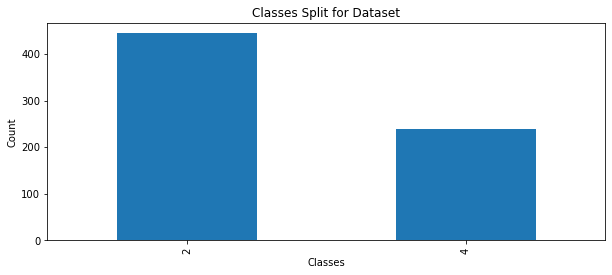

In [25]:
#Class Balance
print('Class Split')
print(dataset['Class'].value_counts())
dataset['Class'].value_counts().plot.bar(figsize=(10,4),title='Classes Split for Dataset')
plt.xlabel('Classes')
plt.ylabel('Count')

In [26]:
#Find Independent Column Correlations
def correlation(dataset,threshold):
    col_corr= [] # List of correlated columns
    corr_matrix=dataset.corr() #finding correlation between columns
    for i in range (len(corr_matrix.columns)): #Number of columns
        for j in range (i):
            if abs(corr_matrix.iloc[i,j])>threshold: #checking correlation between columns
                colName=(corr_matrix.columns[i], corr_matrix.columns[j]) #getting correlated columns
                col_corr.append(colName) #adding correlated column name
    return col_corr #returning set of column names
col=correlation(dataset,0.8)
print('Correlated columns @ 0.8:', col)

Correlated columns @ 0.8: [('UofCShape', 'UofCSize'), ('Class', 'UofCSize'), ('Class', 'UofCShape'), ('Class', 'Bare Nuclei')]


In [27]:
#Define x and y variable
x = dataset.drop(['Class','id'],axis=1).to_numpy()
y = dataset['Class'].to_numpy()

# Create Train and Test Datasets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20,stratify=y,random_state=100)

#Scale the Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train2 = sc.fit_transform(x_train)
x_test2 = sc.transform(x_test)

#Model
from sklearn.linear_model import LogisticRegression

In [28]:
#Base Logistical Regression Model
from sklearn.metrics import classification_report, confusion_matrix  

for name,method in [('LogReg', LogisticRegression(solver='lbfgs',class_weight='balanced',
                                               random_state=100))]: 
    method.fit(x_train2,y_train)
    predict = method.predict(x_test2)
    print('\nEstimator: {}'.format(name)) 
    print(confusion_matrix(y_test,predict))  
    print(classification_report(y_test,predict))          


Estimator: LogReg
[[89  0]
 [ 2 46]]
              precision    recall  f1-score   support

           2       0.98      1.00      0.99        89
           4       1.00      0.96      0.98        48

    accuracy                           0.99       137
   macro avg       0.99      0.98      0.98       137
weighted avg       0.99      0.99      0.99       137



In [29]:
#Construct some pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Create Pipeline

pipeline =[]

pipe_logreg = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(solver='lbfgs',class_weight='balanced',
                                               random_state=100))])
pipeline.insert(0,pipe_logreg)

#Set grid search params 

modelpara =[]

param_gridlogreg = {'clf__C': [0.01, 0.1, 1, 10, 100], 
                    'clf__penalty': ['l2']}
modelpara.insert(0,param_gridlogreg)

In [30]:
#Define Plot for learning curve

from sklearn.model_selection import learning_curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=x_train, 
                                                            y=y_train,
                                                            train_sizes= np.linspace(0.1, 1.0, 10),
                                                            cv=10,
                                                            scoring='recall_weighted',random_state=100)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean,color='blue', marker='o', 
             markersize=5, label='training recall')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation recall')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid(True)
    plt.xlabel('Number of training samples')
    plt.ylabel('Recall')
    plt.legend(loc='best')
    plt.ylim([0.5, 1.01])
    plt.show()

Logisistic Regression - Learning Curve


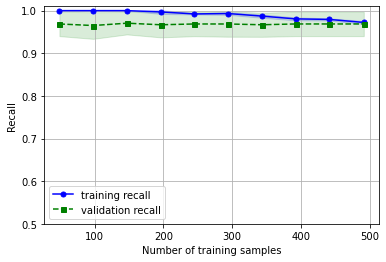

In [31]:
#Plot Learning Curve
print('Logisistic Regression - Learning Curve')
plot_learning_curves(pipe_logreg)

Model Evaluation - Recall Weighted
Logistic Regression 0.97 +/- 0.02




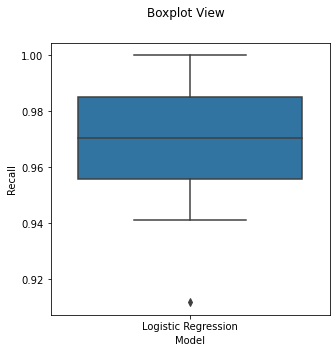

In [33]:
#Model Analysis
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

models=[]
models.append(('Logistic Regression',pipe_logreg))

#Model Evaluation
results =[]
names=[]
scoring ='recall_weighted'
print('Model Evaluation - Recall Weighted')
for name, model in models:
    rkf=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    cv_results = cross_val_score(model,x,y,cv=rkf,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print('{} {:.2f} +/- {:.2f}'.format(name,cv_results.mean(),cv_results.std()))
print('\n')

fig = plt.figure(figsize=(5,5))
fig.suptitle('Boxplot View')
ax = fig.add_subplot(111)
sns.boxplot(data=results)
ax.set_xticklabels(names)
plt.ylabel('Recall')
plt.xlabel('Model')
plt.show()

In [34]:
#Define Gridsearch Function

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix  

def Gridsearch_cv(model, params):
    
    #Cross-validation Function
    cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
        
    #GridSearch CV
    gs_clf = GridSearchCV(model, params, cv=cv2,scoring='recall_weighted')
    gs_clf = gs_clf.fit(x_train, y_train)
    model = gs_clf.best_estimator_
    
    # Use best model and test data for final evaluation
    y_pred = model.predict(x_test)
    
    #Identify Best Parameters to Optimize the Model
    bestpara=str(gs_clf.best_params_)
    
    #Output Heading
    print('\nOptimized Model')
    print('\nModel Name:',str(pipeline.named_steps['clf']))
        
    #Output Validation Statistics
    target_names=['Outcome 0','Outcome 1']
    print('\nBest Parameters:',bestpara)
    print('\n', confusion_matrix(y_test,y_pred))  
    print('\n',classification_report(y_test,y_pred,target_names=target_names)) 
        
    #Transform the variables into binary (0,1) - ROC Curve
    from sklearn import preprocessing
    Forecast1=pd.DataFrame(y_pred)
    Outcome1=pd.DataFrame(y_test)
    lb1 = preprocessing.LabelBinarizer()
    OutcomeB1 =lb1.fit_transform(Outcome1)
    ForecastB1 = lb1.fit_transform(Forecast1)
    
    #Setup the ROC Curve
    from sklearn.metrics import roc_curve, auc
    from sklearn import metrics
    fpr, tpr, threshold = metrics.roc_curve(OutcomeB1, ForecastB1)
    roc_auc = metrics.auc(fpr, tpr)
    print('ROC Curve')
    #Plot the ROC Curve
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()   


Optimized Model

Model Name: LogisticRegression(class_weight='balanced', random_state=100)

Best Parameters: {'clf__C': 0.01, 'clf__penalty': 'l2'}

 [[88  1]
 [ 1 47]]

               precision    recall  f1-score   support

   Outcome 0       0.99      0.99      0.99        89
   Outcome 1       0.98      0.98      0.98        48

    accuracy                           0.99       137
   macro avg       0.98      0.98      0.98       137
weighted avg       0.99      0.99      0.99       137

ROC Curve


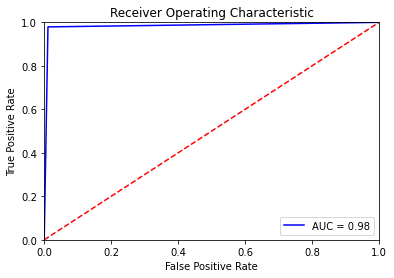

In [35]:
#Run Models

for pipeline, modelpara in zip(pipeline,modelpara):
    Gridsearch_cv(pipeline,modelpara)

In [38]:
#Next Steps - Feature Selection using SelectFromModel
from sklearn.feature_selection import SelectFromModel
clf = LogisticRegression(solver='liblinear',class_weight='balanced',
                                               random_state=100)
clf.fit(x_train2,y_train)
model = SelectFromModel(clf, prefit=True)
feature_idx = model.get_support()
feature_name = dataset.drop(['Class', 'id'],axis=1).columns[feature_idx]
print('\nKey Features:',feature_name)


Key Features: Index(['Clump Thickness', 'Marginal Adhesion', 'Bare Nuclei',
       'Bland Chromatin', 'Normal Nucleoli'],
      dtype='object')
